# Import

In [1]:
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy
import scipy.io as sio
from scipy.io import readsav

#below are ones that I added
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Label, LabelSet,BoxAnnotation
output_notebook()


#Global Variables (This is bad, do not emulate my bad programming)
NORMALIZATION_INDEX = 800 #420 #I dunno pick one

Loading BokehJS ...

In [2]:
region_1a = readsav('venus_1118_total_ortho_30jun21.sav') #night 1
region_2a = readsav('venus_1198_total_ortho_30jun21.sav') #night 1
region_1b = readsav('venus_1118_total_ortho_32jun21.sav') #night 2
region_2b = readsav('venus_1198_total_ortho_32jun21.sav') #night 2

In [3]:
#Print the wavenumber ranges
print("Region 1 Night 1:")
print(str(region_1a['wavenumber'][0]) + ' - ' + str(region_1a['wavenumber'][-1]))
print("Region 1 Night 2:")
print(str(region_1b['wavenumber'][0]) + ' - ' + str(region_1b['wavenumber'][-1]))

print("Region 2 Night 1:")
print(str(region_2a['wavenumber'][0]) + ' - ' + str(region_2a['wavenumber'][-1]))
print("Region 2 Night 2:")
print(str(region_2b['wavenumber'][0]) + ' - ' + str(region_2b['wavenumber'][-1]))

Region 1 Night 1:
1114.7114576040406 - 1122.9214809483474
Region 1 Night 2:
1115.4770923657948 - 1123.696475590839
Region 2 Night 1:
1193.5328127792955 - 1199.8271367294074
Region 2 Night 2:
1193.5986894273308 - 1199.8973422398797


In [4]:
#Figure out what we got
print(region_1a.keys())
print(region_2b.hdr)
#print(region_1a.map_pixel_scale)
#print(region_1b.vel_map[10])

dict_keys(['spec_cube', 'sky', 'wavenumber', 'hdr', 'latitude', 'longitude', 'airmass', 'vel_map', 'mapgrid', 'inttime', 'map_pixel_scale', 'contmap', 'emismap'])
[b'filename= ven.7040                                                             '
 b'object  = Venus                                                                '
 b'PI      = Sousa           '
 b'feature = ph3                                                                  '
 b'waveno0 = 1198                                                                 '
 b'order   = 7                                                                    '
 b'temp    =  283.8                                                               '
 b'tau     =                                                                      '
 b'humidity= 40.6                                                                 '
 b'obsmode = scan                                                                 '
 b'telstep = 0.70 E   0.00 N                      

Naming Legend:

numbers are wavelength regions, letters are nights

1 = Region 1

2 = Region 2


a = Night 1

b = Night 2


In [5]:
#Find the pixel with the highest integration time? 

#night 1
size_x1a, size_y1a, size_lambda1a = np.shape(region_1a['spec_cube'])
size_x2a, size_y2a, size_lambda2a = np.shape(region_2a['spec_cube'])

#night 2
size_x1b, size_y1b, size_lambda1b = np.shape(region_1b['spec_cube'])
size_x2b, size_y2b, size_lambda2b = np.shape(region_2b['spec_cube'])

#Night 1
highest_integration_1a = 0
best_x1a,best_y1a = 0,0
highest_integration_2a = 0
best_x2a,best_y2a = 0,0

#Night 2
highest_integration_1b = 0
best_x1b,best_y1b = 0,0
highest_integration_2b = 0
best_x2b,best_y2b = 0,0

#Night 1 region 1
for i in range(size_x1a):
    for j in range(size_y1a):
        for k in range(size_lambda1a):
            if region_1a['inttime'][i,j,k] > highest_integration_1a:
                highest_integration_1a = region_1a['inttime'][i,j,k]
                best_x1a = i
                best_y1a = j
                
#Night 2 region 1
for i in range(size_x1b):
    for j in range(size_y1b):
        for k in range(size_lambda1b):
            if region_1b['inttime'][i,j,k] > highest_integration_1b:
                highest_integration_1b = region_1b['inttime'][i,j,k]
                best_x1b = i
                best_y1b = j

                
#Night 1 region 2                
for i in range(size_x2a):
    for j in range(size_y2a):
        for k in range(size_lambda2a):
            if region_2a['inttime'][i,j,k] > highest_integration_2a:
                highest_integration_2a = region_2a['inttime'][i,j,k]
                best_x2a = i
                best_y2a = j


#Night 2 region 2                
for i in range(size_x2b):
    for j in range(size_y2b):
        for k in range(size_lambda2b):
            if region_2b['inttime'][i,j,k] > highest_integration_2b:
                highest_integration_2b = region_2b['inttime'][i,j,k]
                best_x2b = i
                best_y2b = j
                
print("Indices with highest exposure time Night 1:")
print(best_x1a,best_y1a)
print(best_x2a,best_y2a)

print("Indices with highest exposure time Night 2:")
print(best_x1b,best_y1b)
print(best_x2b,best_y2b)


#For now just pick 20,20, since we sum up over all the bright stuff later anyways
#night 1
best_x1a=20
best_y1a=20
best_x2a= 20
best_y2a=20

#For now pick 40,40 because it is approx the center of Venus for Night 2
#night 2
best_x1b=40
best_y1b=40
best_x2b=40
best_y2b=40

Indices with highest exposure time Night 1:
21 16
23 14
Indices with highest exposure time Night 2:
43 55
45 35


# Data Load In

## Line-by-line Load-in

In [63]:
#import line by line (assuming gathered from HITRAN)
df=pd.read_fwf('/Users/gracesanger-johnson/Downloads/Senior_Project/Grace_Venus_Data_CONFIDENTIAL/line_by_lines/SO2_all_iso.txt',header=None) 
wn=df.loc[:,1]
abund=df.loc[:,2]
split_df=pd.concat([wn,abund],axis=1)
split_array=split_df.to_numpy()
#print(split_array)

#get desired wavenumbers

#Region 1:
mol_lambda1=[]
abund_lambda1=[]
for a in range(0,len(split_array),1):
    if split_array[a,0] > 1114.7114576040406 and split_array[a,0] < 1123.696475590839:
        if split_array[a,1] > 1e-21: #and split_array[a,1] < 1e-23: #remove the and for the regular limit
            mol_lambda1.append(split_array[a,0]) #get list of wavenumber locations
            abund_lambda1.append(split_array[a,1]) # get corresponding strengths

print(len(mol_lambda1))
range1_array=np.stack((mol_lambda1, abund_lambda1),axis=-1) #make locations and strengths one array
line_locations_region_1 = np.array(mol_lambda1) #make it match previous naming structure

#Region 2:
mol_lambda2=[]
abund_lambda2=[]
for a in range(0,len(split_array),1):
    if split_array[a,0] > 1193.5328127792955 and split_array[a,0] < 1199.8973422398797:
        if split_array[a,1] > 1e-29:
            mol_lambda2.append(split_array[a,0])
            abund_lambda2.append(split_array[a,1])

print(len(mol_lambda2))
range2_array=np.stack((mol_lambda2, abund_lambda2),axis=-1)
line_locations_region_2 = np.array(mol_lambda2)



80
0


## Cross Section Load-in

In [71]:
#Load in cross sections ASSUMING FROM EXOMOL

df=pd.read_table('/Users/gracesanger-johnson/Downloads/Senior_Project/Grace_Venus_Data_CONFIDENTIAL/cross_sections/CO2_05.txt',delimiter=' ', skipinitialspace=True, header=None)
wn=df.loc[:,0]
cross=df.loc[:,1]
split_df=pd.concat([wn,cross],axis=1)
split_array=split_df.to_numpy()

#get desired wavenumbers
loc_lambda1=[]
cross_lambda1=[]
for a in range(0,len(split_array),1):
    if split_array[a,0] > 1114.7114576040406 and split_array[a,0] < 1123.696475590839:
        loc_lambda1.append(split_array[a,0])
        cross_lambda1.append(split_array[a,1])
        
loc_lambda2=[]
cross_lambda2=[]
for a in range(0,len(split_array),1):
    if split_array[a,0] > 1193.5328127792955 and split_array[a,0] < 1199.8973422398797:
        loc_lambda2.append(split_array[a,0])
        cross_lambda2.append(split_array[a,1])

#print(loc_lambda)


So, my original thinking on the unit conversion was to make the cross section units match the absorption strength units. The cross section units are $\mathrm{cm^2/molecule}$ and the absorption strength units are $\mathrm{cm^{-1}/molecule*cm^{-2}}$ However, upon reflection, I realized that this is perhaps silly and meaningless. But, I'm convinced I should do some sort of unit conversion?? Have to figure that out. For now, probs best to skip the next block of code. 

In [8]:
# on secodn thought this does not make much sense.....
#what are the y axis units of my spectra????
# Make it the same units as the strength from Hitran??? (make it from cm^2/molecule to cm^-1/(molecule/cm^2)) but idkkkkk

inv=1/np.array(cross_lambda) #flip 
#print(inv)

loc_lambda_arr=np.array(loc_lambda) #make wavenumbers into array
#print(loc_lambda_arr[0])

unit_convert=[]
for u_loop in range(0,len(loc_lambda_arr)):
    temp_convert=(loc_lambda_arr[u_loop])*(inv[u_loop]) #multiply by wavenumber
    unit_convert = np.append(unit_convert, temp_convert)
#print(unit_convert)


NameError: name 'cross_lambda' is not defined

# Global Spectra

## Region 1

In [19]:
#Create Globally Summed Spectrum

#night 1
global_lambda1a = []
global_flux1a = []
for i in range(len(region_1a['wavenumber'])):
    global_lambda1a.append(region_1a['wavenumber'][i])
    the_sum1a=0
    for j in np.linspace(best_x1a-5,best_x1a+5,num=11):
        for k in np.linspace(best_y1a-7,best_y1a+7,num=15):
            the_sum1a = the_sum1a + region_1a['spec_cube'][int(j),int(k),int(i)]
    global_flux1a.append(the_sum1a)

#night 2

global_lambda1b = []
global_flux1b = []
for i in range(len(region_1b['wavenumber'])):
    global_lambda1b.append(region_1b['wavenumber'][i])
    the_sum1b=0
    for j in np.linspace(best_x1b-5,best_x1b+5,num=11):
        for k in np.linspace(best_y1b-7,best_y1b+7,num=15):
            the_sum1b = the_sum1b + region_1b['spec_cube'][int(j),int(k),int(i)]
    global_flux1b.append(the_sum1b)

When I was identifying the location of the band centers, I also wanted to be able to compare the absorption strengths. It takes the general range and divides it by 5. Otherwise, it is not physically signifigant.  

In [35]:
#Region 1 relative strength bands
lower_range1=0.14
upper_range1=1.17
total_range1=upper_range1-lower_range1
print('total range is', total_range1)
band_width1=(total_range1)/5

b5_1=lower_range1
b4_1=b5_1+band_width1
b3_1=b4_1+band_width1
b2_1=b3_1+band_width1
b1_1=b2_1+band_width1


total range is 1.0299999999999998


The below plot should be fully interactive. If you also plot the line-by-line data, hovering over that line should tell you the absorption strength of that line.

In [89]:
# plotting together (Region 1)
TOOLTIPS = [ ("x","$x{‘00.00000000’}"),("y","$y{‘00.000’}"), ("strength", "$name")]

q = figure(title="Wavenumber Region 1 Night 2 Absorption Cross-Section Comparison",sizing_mode="stretch_width",
    height=550,tooltips=TOOLTIPS)

#'$\mathrm{log_{10}[\lambda]\ (\lambda\ in\ Gyr^{-1})}$'

#q.line(global_lambda1a,global_flux1a / np.median(global_flux1a),legend_label='Venus N1', color='blue') #night 1 venus
q.line(global_lambda1b,global_flux1b / np.median(global_flux1b),legend_label='Venus N2', color='red') #night 2 venus

#q.line(region_1a['wavenumber'],-.1+region_1a['sky'][best_x1a,best_y1a] / region_1a['sky'][best_x1a,best_y1a,NORMALIZATION_INDEX],legend_label='sky N1',color='green') #night 1 sky
q.line(region_1b['wavenumber'],-.1+region_1b['sky'][best_x1b,best_y1b] / region_1b['sky'][best_x1b,best_y1b,NORMALIZATION_INDEX],legend_label='sky N2',color='orange') #night 2 sky

#add line-by-line
#for place in range(0,len(line_locations_region_1)):
    #q.line([range1_array[place,0],range1_array[place,0]], [1.06,0.60],color='black',line_width=1,name=str(range1_array[place,1]))

#add cross-section (no unit correction aka as is from exomol)
#q.line(np.array(loc_lambda1)+0.03,(np.array(cross_lambda1)*(-1)*10**(19)+1),legend_label='Doppler Corrected cross-section shift', color='red') #flip, shift up, make comparable mag
q.line(loc_lambda1,(np.array(cross_lambda1)*(-1)*10**(27)+1),legend_label='cross-section', color='black') #flip, shift up, make comparable mag




#add relative strength boxes
strength_1 = BoxAnnotation(bottom=b1_1, top=upper_range1, fill_alpha=0.3, fill_color='#2AF7BA')
strength_2 = BoxAnnotation(bottom=b2_1, top=b1_1, fill_alpha=0.3, fill_color='#3FBDCB')
strength_3 = BoxAnnotation(bottom=b3_1, top=b2_1, fill_alpha=0.3, fill_color='#5583DD')
strength_4 = BoxAnnotation(bottom=b4_1, top=b3_1, fill_alpha=0.3, fill_color='#6A49EE')
strength_5 = BoxAnnotation(bottom=b5_1, top=b4_1, fill_alpha=0.3, fill_color='#7F0FFF')
q.add_layout(strength_1)
#q.add_layout(strength_2)
#q.add_layout(strength_3)
#q.add_layout(strength_4)
#q.add_layout(strength_5)

show(q)


## Region 2

In [54]:
#Create Globally Summed Spectrum

#Night 1
global_lambda2a = []
global_flux2a = []
for i in range(len(region_2a['wavenumber'])):
    global_lambda2a.append(region_2a['wavenumber'][i])
    the_sum2a=0
    for j in np.linspace(best_x2a-5,best_x2a+5,num=11):
        for k in np.linspace(best_y2a-5,best_y2a+5,num=15):
            the_sum2a = the_sum2a + region_2a['spec_cube'][int(j),int(k),int(i)]
    global_flux2a.append(the_sum2a)
    
#Night 2
global_lambda2b = []
global_flux2b = []
for i in range(len(region_2b['wavenumber'])):
    global_lambda2b.append(region_2b['wavenumber'][i])
    the_sum2b=0
    for j in np.linspace(best_x2b-7,best_x2b+7,num=11):
        for k in np.linspace(best_y2b-7,best_y2b+7,num=15):
            the_sum2b = the_sum2b + region_2b['spec_cube'][int(j),int(k),int(i)]
    global_flux2b.append(the_sum2b)

In [55]:
#Region 2 relative strength bands
lower_range2=0.32 #y loc of lowest point (band center)
upper_range2=1.07 #y loc of about highest data points
total_range2=upper_range2-lower_range2
print('total range is', total_range2)
band_width2=(total_range2)/5
print('band width is', band_width2)
b5_2=lower_range2
b4_2=b5_2+band_width2
b3_2=b4_2+band_width2
b2_2=b3_2+band_width2
b1_2=b2_2+band_width2


total range is 0.75
band width is 0.15


In [59]:
#global with strengths
TOOLTIPS = [ ("x","$x{‘00.00000000’}"), ("y","$y{‘00.000’}"),("strength", "$name")]

q = figure(title="Wavenumber Region 2 Night 1 Global Flux", sizing_mode="stretch_width",
    height=550,tooltips=TOOLTIPS)
#x_axis_label="wavenumber", y_axis_label="flux",

q.line(global_lambda2a,global_flux2a / np.median(global_flux2a),legend_label='Venus N1', color='blue')
#q.line(global_lambda2b,global_flux2b / np.median(global_flux2b),legend_label='Venus N2', color='red')


q.line(region_2a['wavenumber'],-.1+region_2a['sky'][best_x2a,best_y2a] / region_2a['sky'][best_x2a,best_y2a,NORMALIZATION_INDEX],legend_label='sky N1',color='green')
#q.line(region_2b['wavenumber'],-.1+region_2b['sky'][best_x2b,best_y2b] / region_2b['sky'][best_x2b,best_y2b,NORMALIZATION_INDEX],legend_label='sky N2',color='orange')


#add line-by-line
#for place in range(0,len(line_locations_region_2)):
    #q.line([range2_array[place,0],range2_array[place,0]], [1.15,0.8],color='black',line_width=1,name=str(range2_array[place,1]))


#add cross-section (no unit correction aka as is from exomol)
#q.line(loc_lambda2,(np.array(cross_lambda2)*(-1)*10**(27)+1),legend_label='cross-section', color='red') #flip, shift up, make comparable mag

#add relative strength boxes
strength_1 = BoxAnnotation(bottom=b1_2, top=upper_range2, fill_alpha=0.3, fill_color='#2AF7BA')
strength_2 = BoxAnnotation(bottom=b2_2, top=b1_2, fill_alpha=0.3, fill_color='#3FBDCB')
strength_3 = BoxAnnotation(bottom=b3_2, top=b2_2, fill_alpha=0.3, fill_color='#5583DD')
strength_4 = BoxAnnotation(bottom=b4_2, top=b3_2, fill_alpha=0.3, fill_color='#6A49EE')
strength_5 = BoxAnnotation(bottom=b5_2, top=b4_2, fill_alpha=0.3, fill_color='#7F0FFF')
#q.add_layout(strength_1)
#q.add_layout(strength_2)
#q.add_layout(strength_3)
#q.add_layout(strength_4)
#q.add_layout(strength_5)


show(q)

# Spacial Spectra (individual pixels)

## Region 1

### Night 1

In [108]:
p = figure(title="Night 1 Wavenumber Region 1",sizing_mode="stretch_width", height=550,)

#p = figure(title="Night 1 Wavenumber Region 1", x_axis_label="wavenumber", y_axis_label="flux",sizing_mode="stretch_width", height=550,)
p.line(global_lambda1a,global_flux1a / np.median(global_flux1a),legend_label='Global', color='red') #night 1 venus
p.line(region_1a['wavenumber'],-.1+region_1a['sky'][best_x1a,best_y1a] / region_1a['sky'][best_x1a,best_y1a,NORMALIZATION_INDEX],legend_label='sky N1',color='blue')


p.line(region_1a['wavenumber'],region_1a['spec_cube'][best_x1a,best_y1a] / region_1a['spec_cube'][best_x1a,best_y1a,NORMALIZATION_INDEX],legend_label=str(best_x1a)+', '+str(best_y1a), color='black')
p.line(region_1a['wavenumber'],region_1a['spec_cube'][best_x1a+4,best_y1a+5] / region_1a['spec_cube'][best_x1a+4,best_y1a+5,NORMALIZATION_INDEX],legend_label=str(best_x1a+4)+', '+str(best_y1a+5), color='magenta')
p.line(region_1a['wavenumber'],region_1a['spec_cube'][best_x1a-1,best_y1a-2] / region_1a['spec_cube'][best_x1a-1,best_y1a-2,NORMALIZATION_INDEX],legend_label=str(best_x1a-1)+', '+str(best_y1a-2),color='green')

#p.line(region_1a['wavenumber'],.02+region_1a['sky'][best_x1a,best_y1a] / region_1a['sky'][best_x1a,best_y1a,NORMALIZATION_INDEX],legend_label='sky', color='red')

#Include line-by-line:
#for place in line_locations_region_1:
    #p.line([place,place],[1.06,0.60],color='black',line_width=1)
    
p.line(region_1a['wavenumber'],1.05,legend_label='Venus baseline',color='black')
p.line(region_1a['wavenumber'],0.9,legend_label='Sky baseline',color='black')

show(p)

### Night 2

In [ ]:
p = figure(title="Night 2 Region 1", x_axis_label="wavenumber", y_axis_label="flux",sizing_mode="stretch_width",
    height=550,)
p.line(region_1b['wavenumber'],region_1b['spec_cube'][best_x1b,best_y1b] / region_1b['spec_cube'][best_x1b,best_y1b,NORMALIZATION_INDEX],legend_label=str(best_x1b)+', '+str(best_y1b), color='blue')
p.line(region_1b['wavenumber'],region_1b['spec_cube'][best_x1b+2,best_y1b+2] / region_1b['spec_cube'][best_x1b+2,best_y1b+2,NORMALIZATION_INDEX],legend_label=str(best_x1b+2)+', '+str(best_y1b+2), color='orange')
p.line(region_1b['wavenumber'],region_1b['spec_cube'][best_x1b-2,best_y1b-2] / region_1b['spec_cube'][best_x1b-2,best_y1b-2,NORMALIZATION_INDEX],legend_label=str(best_x1b-2)+', '+str(best_y1b-2),color='green')

p.line(region_1b['wavenumber'],.02+region_1b['sky'][best_x1b,best_y1b] / region_1b['sky'][best_x1b,best_y1b,NORMALIZATION_INDEX],legend_label='sky', color='red')

#include line-by-line:
#for place in line_locations_region_1:
    #p.line([place,place],[1.06,0.60],color='black',line_width=1)
show(p)

## Region 2

### Night 1

In [ ]:
p = figure(title="Night 1 Region 1", x_axis_label="wavenumber", y_axis_label="flux",sizing_mode="stretch_width",
    height=550,)
p.line(region_2a['wavenumber'],region_2a['spec_cube'][best_x2a,best_y2a] / region_2a['spec_cube'][best_x2a,best_y2a,NORMALIZATION_INDEX],legend_label=str(best_x2a)+', '+str(best_y2a), color='blue')
p.line(region_2a['wavenumber'],region_2a['spec_cube'][best_x2a+2,best_y2a+2] / region_2a['spec_cube'][best_x2a+2,best_y2a+2,NORMALIZATION_INDEX],legend_label=str(best_x2a+2)+', '+str(best_y2a+2), color='orange')
p.line(region_2a['wavenumber'],region_2a['spec_cube'][best_x2a-2,best_y2a-2] / region_2a['spec_cube'][best_x2a-2,best_y2a-2,NORMALIZATION_INDEX],legend_label=str(best_x2a-2)+', '+str(best_y2a-2),color='green')

p.line(region_2a['wavenumber'],.02+region_2a['sky'][best_x2a,best_y2a] / region_2a['sky'][best_x2a,best_y2a,NORMALIZATION_INDEX],legend_label='sky', color='red')

#Include line-by-line:
#for place in line_locations_region_2:
    #p.line([place,place],[1.06,0.60],color='black',line_width=1)
show(p)

### Night 2

In [ ]:
p = figure(title="Night 2 Region 2", x_axis_label="wavenumber", y_axis_label="flux",sizing_mode="stretch_width",
    height=550,)
p.line(region_2b['wavenumber'],region_2b['spec_cube'][best_x2b,best_y2b] / region_2b['spec_cube'][best_x2b,best_y2b,NORMALIZATION_INDEX],legend_label=str(best_x2b)+', '+str(best_y2b), color='blue')
p.line(region_2b['wavenumber'],region_2b['spec_cube'][best_x2b+2,best_y2b+2] / region_2b['spec_cube'][best_x2b+2,best_y2b+2,NORMALIZATION_INDEX],legend_label=str(best_x2b+2)+', '+str(best_y2b+2), color='orange')
p.line(region_2b['wavenumber'],region_2b['spec_cube'][best_x2b-2,best_y2b-2] / region_2b['spec_cube'][best_x2b-2,best_y2b-2,NORMALIZATION_INDEX],legend_label=str(best_x2b-2)+', '+str(best_y2b-2),color='green')

p.line(region_2b['wavenumber'],.02+region_2b['sky'][best_x2b,best_y2b] / region_2b['sky'][best_x2b,best_y2b,NORMALIZATION_INDEX],legend_label='sky', color='red')

#include line-by-line:

#for place in line_locations_region_2:
    #p.line([place,place],[1.06,0.60],color='black',line_width=1)

show(p)

# Contour Plots

## Region 1

### Night 1

In [ ]:
print((best_x1a+5)-(best_x1a-5))
print(

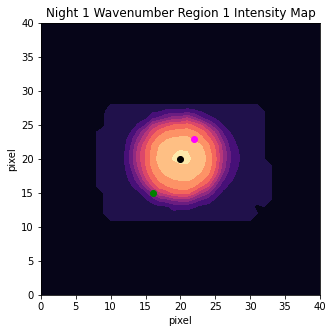

In [107]:
#see contour map of view
z = np.zeros((int(size_y1a), int(size_y1a)))
for i in range(size_x1a):
    for j in range(size_y1a):
        z[i,j] = np.sum(region_1a['spec_cube'][i,j])
        #print(np.sum(region_1['spec_cube'][i,j]))
#print(z)
Figure = plt.figure(figsize=(5,5))
#plt.contour(z, levels=8)
plt.contourf(z, levels=9,cmap='magma')

plt.title('Night 1 Wavenumber Region 1 Intensity Map')

plt.xlabel('pixel')
plt.ylabel('pixel')

#add dots where the individual spectra are coming from
plt.scatter(best_x1a,best_x1a,color='black')
plt.scatter(best_x1a-4,best_y1a-5,color='green')
plt.scatter(best_x1a+2,best_y1a+3,color='magenta')


#add dots that mark boundaries for global flux area
#plt.scatter(best_x1a+5,best_y1a+7,color='red')
#plt.scatter(best_x1a-5,best_y1a-7,color='black')

#make rectable of global flux area
left, bottom, width, height = (best_x1a-5, best_y1a-7, (best_x1a+5)-(best_x1a-5), (best_y1a+7)-(best_y1a-7))
rect=patches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="red",
                       linewidth=2)
                       
#plt.gca().add_patch(rect)


plt.savefig('/Users/gracesanger-johnson/Downloads/Senior_Project/insert/N1_R1_individual_Contour_ozone.png',format='png',bbox_inches='tight')

### Night 2

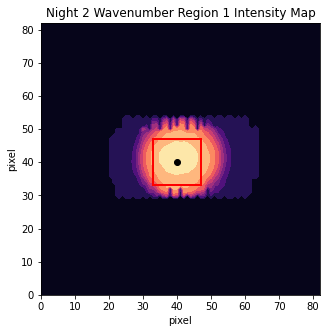

In [52]:
#see contour map of view
z = np.zeros((int(size_y1b), int(size_y1b)))
for i in range(size_x1b):
    for j in range(size_y1b):
        z[i,j] = np.sum(region_1b['spec_cube'][i,j])
        #print(np.sum(region_1['spec_cube'][i,j]))
#print(z)
Figure = plt.figure(figsize=(5,5))
#plt.contour(z, levels=8)

plt.contourf(z, levels=9,cmap='magma')

plt.title('Night 2 Wavenumber Region 1 Intensity Map')
plt.xlabel('pixel')
plt.ylabel('pixel')

#add dots where the individual spectra are coming from
plt.scatter(best_x1b,best_x1b,color='black')
#plt.scatter(best_x1b-2,best_y1b-3,color='blue')
#plt.scatter(best_x1b+2,best_y1b+3,color='green')

#add dots that mark boundaries for global flux area
#plt.scatter(best_x1b+5,best_y1b+7,color='black')
#plt.scatter(best_x1b-5,best_y1b-7,color='black')

#make rectable of global flux area
left, bottom, width, height = (best_x1b-7, best_y1b-7, (best_x1b+7)-(best_x1b-7), (best_y1b+7)-(best_y1b-7))
rect=patches.Rectangle((left,bottom),width,height,
                        fill=False,
                        color="red",
                       linewidth=2)
                       
plt.gca().add_patch(rect)


#plt.savefig('/Users/gracesanger-johnson/Downloads/Senior_Project/Spectra_Pictures/N2_R1_Contour.png',format='png',bbox_inches='tight'
plt.savefig('/Users/gracesanger-johnson/Downloads/Senior_Project/insert/N2_R1_Contour.png',format='png',bbox_inches='tight')


## Region 2

### Night 1

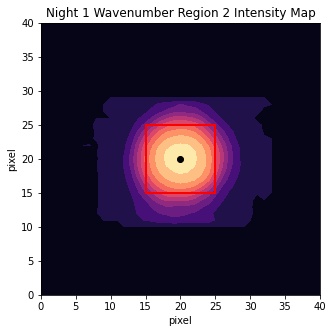

In [30]:
#see contour map of view
z = np.zeros((int(size_y2a), int(size_y2a)))
for i in range(size_x2a):
    for j in range(size_y2a):
        z[i,j] = np.sum(region_2a['spec_cube'][i,j])
        #print(np.sum(region_1['spec_cube'][i,j]))
#print(z)
Figure = plt.figure(figsize=(5,5))
#plt.contour(z, levels=8)

plt.contourf(z, levels=9,cmap='magma')

plt.title('Night 1 Wavenumber Region 2 Intensity Map')
plt.xlabel('pixel')
plt.ylabel('pixel')

#add dots where the individual spectra are coming from
plt.scatter(best_x2a,best_x2a,color='black')
#plt.scatter(best_x2a-2,best_y2a-2,color='orange')
#plt.scatter(best_x2a+2,best_y2a+2,color='red')

#add dots that mark boundaries for global flux area
#plt.scatter(best_x2a+5,best_y2a+5,color='black')
#plt.scatter(best_x2a-5,best_y2a-5,color='black')
left, bottom, width, height = (best_x2a-5, best_y2a-5, (best_x2a+5)-(best_x2a-5), (best_y2a+5)-(best_y2a-5))
rect=patches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="red",
                       linewidth=2)
                       
plt.gca().add_patch(rect)

#plt.savefig('/Users/gracesanger-johnson/Downloads/Senior_Project/Spectra_Pictures/N2_R1_Contour.png',format='png',bbox_inches='tight'
plt.savefig('/Users/gracesanger-johnson/Downloads/Senior_Project/insert/N1_R2_Contour.png',format='png',bbox_inches='tight')



### Night 2

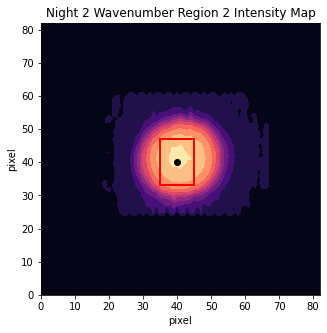

In [34]:
#see contour map of view
z = np.zeros((int(size_y2b), int(size_y2b)))
for i in range(size_x2b):
    for j in range(size_y2b):
        z[i,j] = np.sum(region_2b['spec_cube'][i,j])
        #print(np.sum(region_1['spec_cube'][i,j]))
#print(z)
Figure = plt.figure(figsize=(5,5))
#plt.contour(z, levels=8)

plt.contourf(z, levels=9,cmap='magma')

plt.title('Night 2 Wavenumber Region 2 Intensity Map')
plt.xlabel('pixel')
plt.ylabel('pixel')

#add dots where the individual spectra are coming from
plt.scatter(best_x2b,best_x2b,color='black')
#plt.scatter(best_x2b-2,best_y2b-2,color='orange')
#plt.scatter(best_x2b+2,best_y2b+2,color='red')


#add dots that mark boundaries for global flux area
#lt.scatter(best_x2b+5,best_y2b+7,color='black')
#plt.scatter(best_x2b-5,best_y2b-7,color='black')

left, bottom, width, height = (best_x2b-5, best_y2b-7, (best_x2b+5)-(best_x2b-5), (best_y2b+7)-(best_y2b-7))
rect=patches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="red",
                       linewidth=2)
                       
plt.gca().add_patch(rect)

#plt.savefig('/Users/gracesanger-johnson/Downloads/Senior_Project/Spectra_Pictures/N2_R1_Contour.png',format='png',bbox_inches='tight'
plt.savefig('/Users/gracesanger-johnson/Downloads/Senior_Project/insert/N2_R2_Contour.png',format='png',bbox_inches='tight')


# Doppler Shift Check

In [63]:
#Night 1
v_venus_e=8.67504477 #ephemeris
v_venus_h=-8.73618 #header
c=3*(10**5)
sky_lambda=1120.7631

del_lambda_e=(v_venus_e/c)*sky_lambda
del_lambda_h=(v_venus_h/c)*sky_lambda
print('ephemeris', del_lambda_e)
print('header', del_lambda_h)

ephemeris 0.03240890023021328
header -0.03263729392985999


In [64]:
#Night 2
v_venus_e=8.8421249
v_venus_h=-8.925496
c=3*(10**5)
sky_lambda=1120.7631

del_lambda_e=(v_venus/c)*sky_lambda
del_lambda_h=(v_venus_h/c)*sky_lambda
print('emphemeris', del_lambda_e)
print('header', del_lambda_h)


emphemeris 0.033033091045037294
header -0.033344555219992


# Zenith Checks

In [ ]:
#getting baseline for 1120-1122 window

lower_range1=0.14
upper_range1=1.17
total_range1=upper_range1-lower_range1
print('total range is', total_range1)
band_width1=(total_range1)/5

b5_1=lower_range1
b4_1=b5_1+band_width1
b3_1=b4_1+band_width1
b2_1=b3_1+band_width1
b1_1=b2_1+band_width1


In [97]:
# plotting together (Region 1)
TOOLTIPS = [ ("x","$x{‘00.00000000’}"),("y","$y{‘00.000’}"), ("strength", "$name")]

q = figure(title="Night 2 Region 1 Global Window 1", x_axis_label="wavenumber", y_axis_label="flux",sizing_mode="stretch_width",
    height=550,x_range=(1120, 1122),tooltips=TOOLTIPS)

q.line(global_lambda1a,global_flux1a / np.median(global_flux1a),legend_label='Venus N1', color='blue') #night 1 venus
#q.line(global_lambda1b,global_flux1b / np.median(global_flux1b),legend_label='Venus N2', color='red') #night 2 venus

q.line(region_1a['wavenumber'],-.1+region_1a['sky'][best_x1a,best_y1a] / region_1a['sky'][best_x1a,best_y1a,NORMALIZATION_INDEX],legend_label='sky N1',color='green') #night 1 sky
#q.line(region_1b['wavenumber'],-.1+region_1b['sky'][best_x1b,best_y1b] / region_1b['sky'][best_x1b,best_y1b,NORMALIZATION_INDEX],legend_label='sky N2',color='orange') #night 2 sky

#add line-by-line
#for place in range(0,len(line_locations_region_1)):
    #q.line([range1_array[place,0],range1_array[place,0]], [1.06,0.60],color='black',line_width=1,name=str(range1_array[place,1]))

#add cross-section (no unit correction aka as is from exomol)
#q.line(loc_lambda1,(np.array(cross_lambda1)*(-1)*10**(19)+1),legend_label='cross-section', color='black') #flip, shift up, make comparable mag








#add baseline
q.line(region_1a['wavenumber'],1.05,legend_label='Venus baseline',color='black')
q.line(region_1a['wavenumber'],0.9,legend_label='Sky baseline',color='black')

show(q)

# Getting Latitudinal Differences


## Finding Ephemeris to TEXES shift

In [ ]:
#N1R1
eph_c_ra=08 29 31.19
eph_c_dec=20 41 07.6

hdr_c_ra=08 29 17.66
hdr_c_dec=20 41 36.6


np_ra= #degrees

FOr right now, say that the center of the planet is at 20,20

In [65]:
#get distance between the two points
#night 1 c ra =127.38
#night 2 c ra =129.89


eph_c_ra=127.38 #night1
eph_c_dec=20.68544


eph_np_ra=272.76000
eph_np_dec=67.16000


diff_ra=eph_np_ra-eph_c_ra
diff_dec=eph_np_dec-eph_c_dec

print(diff_ra)
print(diff_dec)

145.38
46.47456


## Region 1

In [ ]:
#adopt global average to get area spectra
#night 1
global_lambda1a = []
global_flux1a = []
for i in range(len(region_1a['wavenumber'])):
    global_lambda1a.append(region_1a['wavenumber'][i])
    the_sum1a=0
    for j in np.linspace(best_x1a-5,best_x1a+5,num=11):
        for k in np.linspace(best_y1a-7,best_y1a+7,num=15):
            the_sum1a = the_sum1a + region_1a['spec_cube'][int(j),int(k),int(i)]
    global_flux1a.append(the_sum1a)

#night 2

global_lambda1b = []
global_flux1b = []
for i in range(len(region_1b['wavenumber'])):
    global_lambda1b.append(region_1b['wavenumber'][i])
    the_sum1b=0
    for j in np.linspace(best_x1b-5,best_x1b+5,num=11):
        for k in np.linspace(best_y1b-7,best_y1b+7,num=15):
            the_sum1b = the_sum1b + region_1b['spec_cube'][int(j),int(k),int(i)]
    global_flux1b.append(the_sum1b)